In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import ConvexHull
plt.rcParams.update({'font.size': 18})

In [2]:
def s_value(a, b):
    return 1 - a - b
    
def F(a, b, A, B, chi_AS, chi_AB, chi_BS):
    s = s_value(a, b)
    return chi_AS * a * s + chi_AB * a * b + chi_BS * b * s + a * np.log(a) / A + b * np.log(b) / B + s * np.log(s)

def d2F_da2(a, b, A, B, chi_AS, chi_AB, chi_BS):
    s = s_value(a, b)
    return -2 * chi_AS + 1 / (a * A) + 1 / s

def d2F_db2(a, b, A, B, chi_AS, chi_AB, chi_BS):
    s = s_value(a, b)
    return -2 * chi_BS + 1 / (b * B) + 1 / s

def d2F_dadb(a, b, A, B, chi_AS, chi_AB, chi_BS):
    s = s_value(a, b)
    return -chi_AS + chi_AB - chi_BS + 1 / s

def Hessian(a, b, A, B, chi_AS, chi_AB, chi_BS):
    H11 = d2F_da2(a, b, A, B, chi_AS, chi_AB, chi_BS)
    H12 = d2F_dadb(a, b, A, B, chi_AS, chi_AB, chi_BS)
    H21 = d2F_dadb(a, b, A, B, chi_AS, chi_AB, chi_BS)
    H22 = d2F_db2(a, b, A, B, chi_AS, chi_AB, chi_BS)
    return np.array([[H11,H12],[H21,H22]])

def Volume_fraction(A, B, numbers):
    V = numbers[0] * A + numbers[1] * B + numbers[2]
    return numbers[0] * A / V, numbers[1] * B /V, V

In [3]:
import numpy as np
from matplotlib.path import Path
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def point_in_area(segments, point, method='convex'):
    """
    Determine whether a point is inside the area roughly defined by line segments.

    Parameters:
        segments: list of pairs of 2D points [ [(x1,y1),(x2,y2)], ... ]
        point: tuple (x, y) to check
        method: 'convex' for ConvexHull, or 'raw' to use all endpoints in sequence

    Returns:
        True if point is inside the area, False otherwise.
    """
    # Collect all endpoints
    all_points = np.array([p for seg in segments for p in seg])

    if method == 'convex':
        try:
            hull = ConvexHull(all_points)
            polygon = all_points[hull.vertices]
        except:
            return False  # Not enough points or degenerate
    else:
        polygon = all_points  # just try to treat as closed polygon if ordered

    path = Path(polygon)
    return path.contains_point(point)


In [4]:
import numpy as np

def signed_distance_to_segment(p, a, b):
    """
    Computes the signed perpendicular distance from point p to line segment ab.
    The sign is based on the 2D cross product (right-hand rule).
    """
    a = np.array(a)
    b = np.array(b)
    p = np.array(p)

    ab = b - a
    ap = p - a
    ab_norm = ab / np.linalg.norm(ab)

    # Perpendicular distance using 2D cross product
    signed_dist = np.cross(ab_norm, ap)

    # Projection factor along segment
    proj = np.dot(ap, ab_norm)
    on_segment = 0 <= proj <= np.linalg.norm(ab)

    return signed_dist, on_segment

def find_bounding_segments(segments, point):
    """
    Finds the two line segments (if any) that the point lies between.

    Parameters:
        segments: list of [(x1, y1), (x2, y2)] segments
        point: (x, y)

    Returns:
        (seg1, seg2): the two closest bounding segments (tuple of segment index and segment)
                     such that the point is between them (on opposite sides).
                     Returns [] if not found.
    """
    signed_dists = []
    for i, (a, b) in enumerate(segments):
        dist, on_seg = signed_distance_to_segment(point, a, b)
        if on_seg:
            signed_dists.append((i, dist, (a, b)))

    # Sort by absolute distance
    signed_dists = sorted(signed_dists, key=lambda x: abs(x[1]))

    # Find two closest segments with opposite signed distance
    for i in range(len(signed_dists)):
        for j in range(i + 1, len(signed_dists)):
            d1 = signed_dists[i][1]
            d2 = signed_dists[j][1]
            if d1 * d2 < 0:  # Opposite sides
                return [signed_dists[i], signed_dists[j]]

    return []


In [5]:
import numpy as np
from scipy.spatial import distance

def sort_boundary_points(points):
    """
    Sort boundary points to form a continuous line starting from the point closest to origin,
    then connecting nearest neighbors.
    
    Args:
        points: List of (x,y) tuples representing boundary points
        
    Returns:
        List of sorted (x,y) tuples forming a continuous boundary
    """
    if not points:
        return []
    
    # Convert to numpy array for easier manipulation
    points_arr = np.array(points)
    
    # 1. Find point closest to origin (0,0)
    dists = np.linalg.norm(points_arr, axis=1)
    start_idx = np.argmin(dists)
    sorted_points = [tuple(points_arr[start_idx])]
    remaining_indices = set(range(len(points_arr))) - {start_idx}
    
    # 2. Greedy algorithm to connect nearest neighbors
    while remaining_indices:
        last_point = np.array(sorted_points[-1])
        
        # Find closest remaining point
        min_dist = float('inf')
        closest_idx = None
        
        for idx in remaining_indices:
            current_dist = np.linalg.norm(points_arr[idx] - last_point)
            if current_dist < min_dist:
                min_dist = current_dist
                closest_idx = idx
        
        if closest_idx is not None:
            sorted_points.append(tuple(points_arr[closest_idx]))
            remaining_indices.remove(closest_idx)
        else:
            break
    
    # 3. Optional: Close the loop by connecting back to start
    if len(sorted_points) > 2:
        # Check if first and last points should be connected
        first_last_dist = np.linalg.norm(np.array(sorted_points[0]) - np.array(sorted_points[-1]))
        avg_dist = np.mean([np.linalg.norm(np.array(sorted_points[i]) - np.array(sorted_points[i+1])) 
                           for i in range(len(sorted_points)-1)])
        
        if first_last_dist < 2 * avg_dist:  # Only close if reasonably close
            sorted_points.append(sorted_points[0])
    
    return sorted_points

[1.2, -0.6, -0.6]


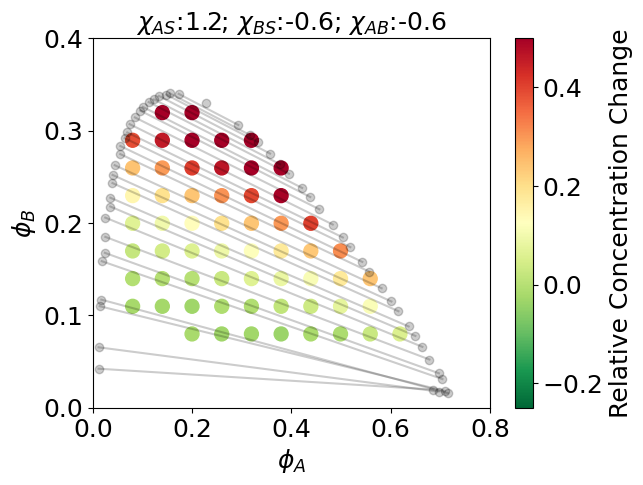

In [ ]:
chi_list = [[1.2, 0.0, 0.0],\
            [1.2, 0.0,-0.6],\
            [1.2, 0.0,-1.2],\
            [1.2,-0.6,-0.6],\
            [1.2,-0.6, 0.0],\
            [1.2,-0.6, 0.6],\
            [1.2, 0.6,-0.6],\
            [1.2, 0.6, 0.0],\
            [1.2, 0.6, 0.6],\
            [1.2, 1.2,-0.6],\
            [1.2, 1.2, 0.0],\
            [0.0, 0.0,-4.0],\
            [1.2, 1.2, 0.6],\
            [0.0, 0.0, 1.0]]

A = 10
B = 10
V_total = 1002
stride_search = 0.2
stride_sample = 3
mins = []
maxs = []

for chi in chi_list:
    print(chi)
    chi_AS = chi[0]
    chi_BS = chi[1]
    chi_AB = chi[2]

    possible_inits = []
    sample_inits = []

    Max_A = int((V_total-2)/A)
    Max_B = int((V_total-2)/B)

    for NA in range(2,Max_A+1):
        for NB in range(2,Max_B+1):
            if NA*A+NB*B<V_total-1:
                possible_inits.append([NA, NB, V_total-(NA*A+NB*B)])

    for NA in range(2,Max_A+1, stride_sample*2):
        for NB in range(2,Max_B+1, stride_sample):
            if NA*A+NB*B<V_total-1:
                sample_inits.append([NA, NB, V_total-(NA*A+NB*B)])

    init_volume_fracs = []
    for init in possible_inits:
        init_volume_fracs.append(Volume_fraction(A, B, init))

    detHs = []
    for volume_frac in init_volume_fracs:
        detHs.append(np.linalg.det(Hessian(volume_frac[0], volume_frac[1], A, B, chi_AS, chi_AB, chi_BS)))

    detH_matrix = np.ones((Max_A+1, Max_B+1))
    for k, init in enumerate(possible_inits):
        detH_matrix[init[0], init[1]] = detHs[k]

    phases_min = np.load('FH-V_' + str(V_total) + '-size_' + str(A) + '_' + str(A) + '-chi_' + str(chi_AS) + '_' + str(chi_BS) + '_' + str(chi_AB) + '-finer_stride' + str(stride_search) + '.npy')

    levels = np.arange(-20, 20, 20)
    plt.xlim(0,0.8)
    plt.ylim(0,0.4)

    plt.xlabel('$\phi_{A}$')
    plt.ylabel('$\phi_{B}$')
    plt.title('$\chi_{AS}$:' + str(chi_AS) + '; $\chi_{BS}$:' + str(chi_BS) + '; $\chi_{AB}$:' + str(chi_AB), fontsize=18)

    tie_lines = []
    tie_lines_ = []
    for phase_min in phases_min:
        tie_lines_.append(np.hstack([phase_min[0:2], phase_min[3:5]]))
        tie_lines.append([phase_min[0:2], phase_min[3:5]])
    tie_lines_sort = np.array(tie_lines_)[np.argsort(np.min(np.array(tie_lines_)[:,1:4:2], axis=1))]
    for tie_line in tie_lines_sort[::4]:
        plt.plot(tie_line[0::2], tie_line[1::2], marker='o', color='black', alpha=0.2)
    plt.scatter(0.22855247, 0.32935101,marker='o', color='black', alpha=0.2)

    sample_init_volume_fracs = []
    densities = []
    for init in sample_inits:
        volume_frac = Volume_fraction(A, B, init)[0:2]
        if point_in_area(tie_lines, np.array(volume_frac)/2) and point_in_area(tie_lines, np.array(volume_frac)):
            bounding = find_bounding_segments(tie_lines, np.array(volume_frac))
            bounding_half = find_bounding_segments(tie_lines, np.array(volume_frac)/2)
            if len(bounding)==0 or len(bounding_half)==0:
                continue
            else:
                sample_init_volume_fracs.append(volume_frac)
                a_dens = (max(bounding[0][2][0][0], bounding[0][2][1][0]) + max(bounding[1][2][0][0], bounding[1][2][1][0])) / 2
                a_dilu = (min(bounding[0][2][0][0], bounding[0][2][1][0]) + min(bounding[1][2][0][0], bounding[1][2][1][0])) / 2
                b_dens = (max(bounding[0][2][0][1], bounding[0][2][1][1]) + max(bounding[1][2][0][1], bounding[1][2][1][1])) / 2
                b_dilu = (min(bounding[0][2][0][1], bounding[0][2][1][1]) + min(bounding[1][2][0][1], bounding[1][2][1][1])) / 2
                a_dens_half = (max(bounding_half[0][2][0][0], bounding_half[0][2][1][0]) + max(bounding_half[1][2][0][0], bounding_half[1][2][1][0])) / 2
                a_dilu_half = (min(bounding_half[0][2][0][0], bounding_half[0][2][1][0]) + min(bounding_half[1][2][0][0], bounding_half[1][2][1][0])) / 2
                b_dens_half = (max(bounding_half[0][2][0][1], bounding_half[0][2][1][1]) + max(bounding_half[1][2][0][1], bounding_half[1][2][1][1])) / 2
                b_dilu_half = (min(bounding_half[0][2][0][1], bounding_half[0][2][1][1]) + min(bounding_half[1][2][0][1], bounding_half[1][2][1][1])) / 2
                densities.append([a_dens, a_dilu, b_dens, b_dilu, a_dens_half, a_dilu_half, b_dens_half, b_dilu_half])

    abs_change = np.array(densities)[:,4] - np.array(densities)[:,0]
    rel_change = (np.array(densities)[:,4] - np.array(densities)[:,0]) / np.array(densities)[:,0]
    mins.append(np.min(rel_change))
    maxs.append(np.max(rel_change))
    min_value = np.min(np.array(densities)[:,0:4:4], axis=1)
    plt.scatter(np.array(sample_init_volume_fracs)[:,0], np.array(sample_init_volume_fracs)[:,1], c=rel_change, cmap='RdYlGn_r', vmin=-0.25, vmax=0.5, s=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Relative Concentration Change')
    plt.savefig('FH4-V_' + str(V_total) + '-size_' + str(A) + '_' + str(A) + '-chi_' + str(chi_AS) + '_' + str(chi_BS) + '_' + str(chi_AB) + '-finer_stride' + str(stride_search) + '-rel_change-V7.pdf', bbox_inches='tight')
    plt.show()
    np.savetxt('FH4-V_' + str(V_total) + '-size_' + str(A) + '_' + str(A) + '-chi_' + str(chi_AS) + '_' + str(chi_BS) + '_' + str(chi_AB) + '-finer_stride' + str(stride_search) + '-rel_change_colored_dots-V7.txt',\
                np.hstack([np.array(sample_init_volume_fracs), rel_change.reshape((-1,1))]),delimiter=',', header='phi_A    phi_B   RCC')
    np.savetxt('FH4-V_' + str(V_total) + '-size_' + str(A) + '_' + str(A) + '-chi_' + str(chi_AS) + '_' + str(chi_BS) + '_' + str(chi_AB) + '-finer_stride' + str(stride_search) + '-rel_change_tie_line_dots-V7.txt',\
                tie_lines_sort[::4],delimiter=',', header='phi_A_I    phi_B_I   phi_A_II    phi_B_II')